<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.6'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dftorisv2.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


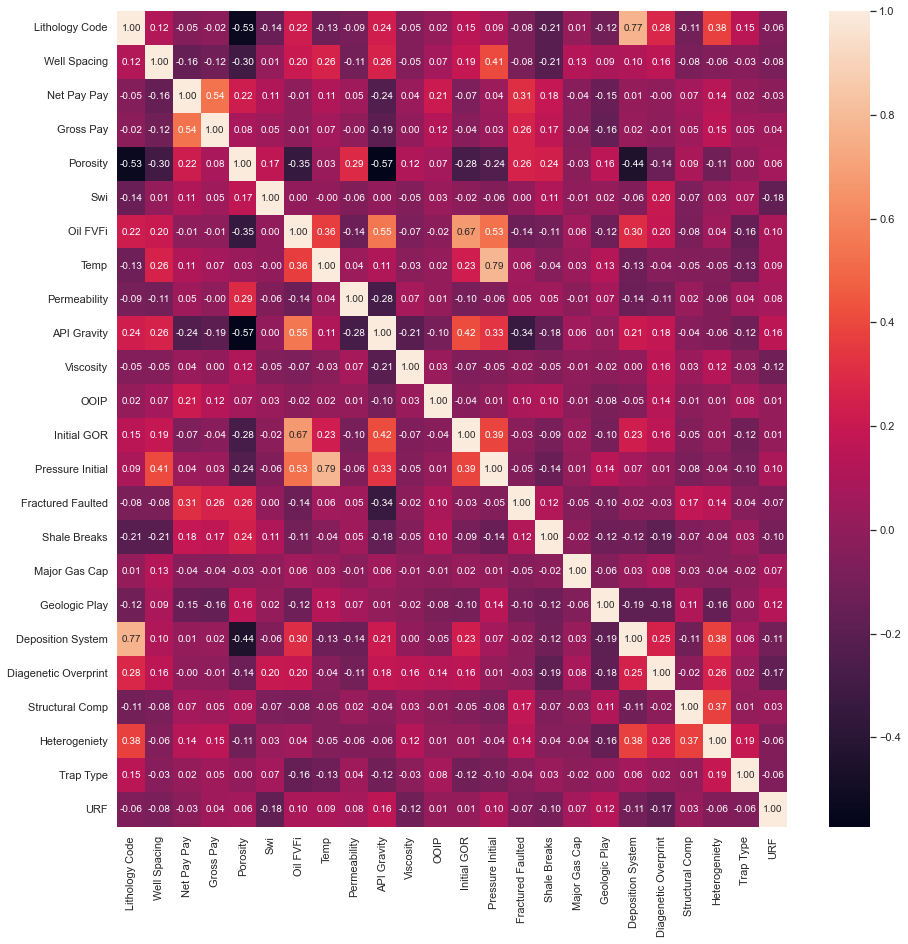

In [7]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As high collinear variables do not add any additional information when it comes to predictive modelling, I will drop "117_Reservoir top subsea depth" and recreate the heat map to check for correlation.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

In [ ]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Drop Structural Flank Dip - does not make much difference to the results and is a difficult input to find for fields

In [ ]:
df_drop = df_drop.drop(['118_Structural flank dip (average) (deg.)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Convert EORIOR to float - to ensure it is a numerical feature

In [ ]:
df_drop['EORIOR'] = df_drop['EORIOR'].astype(float)

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

Final Data set has 436 rows and 19 columns.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [ ]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = '307_Recovery factor (ultimate oil) (%)'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            ignore_low_variance=True,
            train_size=0.7)

In [ ]:
best = compare_models()

In [ ]:
top3_fold_5 = compare_models(include=['rf', 'gbr', 'catboost'], fold = 5, sort='MAE')

In [ ]:
top3 = compare_models(include=['rf', 'gbr', 'catboost'], fold = 10, sort='MAE')

There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

## 2. Plot each Model and Check Features

##### Category Boosting (CatBoost)

In [ ]:
cb = create_model('catboost')
cb_results = pull()
#print(cb_results)

import pandas as pd
cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
#print(cb_feature_imp)
cb_feature_imp.to_csv('Featue_importance_CATBOOST.csv')

In [ ]:
# Given the sheer number of variables, will only plot the first 10
# 'feature_all' will plot everything
plot_model(cb, plot = 'feature')

##### Random Forest (RFR)

In [ ]:
rfr = create_model('rf')
rfr_results = pull()

import pandas as pd
rfr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rfr.feature_importances_)}).sort_values(by='Value', ascending=False)
rfr_feature_imp.to_csv('Feature_importance_RFR.csv')

In [ ]:
plot_model(rfr, plot = 'feature')

##### Gradient Boosting (GBR)

In [ ]:
gbr = create_model('gbr')
gbr_results = pull()
#print(gbr_results)

import pandas as pd
gbr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(gbr.feature_importances_)}).sort_values(by='Value', ascending=False)
gbr_feature_imp.to_csv('Feature_importance_GBR.csv')

In [ ]:
plot_model(gbr, plot = 'feature')

## 3a. Testing for Optimisation - Not necessary to run
-----------------------------------------------------------------------------------

One of the important parameters in the hyperparameters is the number of iterations over which the K fold cross validation is done. 

2 checks are done for this. The first scenario is over the range(0, 1000, 50). The optimisation ran overnight and showed that the ML algorithm did not see much improvement past 50.

In [ ]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # The output from the (0, 1000, 50) is saved; there is no need to run this again. 
# # Line has been modified just so the code can run.
# for i in range(0, 51, 50):
#     start = time.time()
#     if i == 0:
#         i += 1    
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     #print(tuned_cb)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_50_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_50_iter)

In [ ]:
# b = sns.lineplot(data=res_50_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [ ]:
#res.to_csv('Run_Catboost_1000_Itr.csv')

In [ ]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # This was run at (1, 51, 1) to get increments of 1
# # Right now, this is changed to (1, 51, 50) to allow the code to run efficiently
# for i in range(1, 51, 50):
#     start = time.time()
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_1_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_1_iter)

# res_1_iter.to_csv('Run_Catboost_50_Itr.csv')

In [ ]:
# b = sns.lineplot(data=res_1_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [ ]:
# tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 10)

In [ ]:
# plot_model(tuned_cb3, plot = 'parameter')

##### Gradient Boosting Regression

In [ ]:
# gbr = create_model('gbr')
# print(gbr)

In [ ]:
# tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
# print(tuned_gbr)

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

The earlier experiments allow one to determine which model performs efficiently, and the tuning needed to arrive at the answer. Here, we will create the 3 specific models , which we will than blend, and than finally produce a "tuned" blended model based on earlier optimised parameters

from pycaret.distributions import UniformDistribution, CategoricalDistribution

catboost_param_dists = {
    'iterations': CategoricalDistribution([500,100,300]),
    'colsample_bylevel': UniformDistribution(0.5, 1.0),
    'random_strength': CategoricalDistribution([0,0.1,0.2,1,10]),
    'max_depth' : CategoricalDistribution([5,6,7,8,9])
}

In [ ]:
tuned_models = []

In [ ]:
cb = create_model('catboost', fold = 10)
cb = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                #search_library = "optuna", 
                #search_library = "tune-sklearn", 
                #search_algorithm="bayesian",
                #search_algorithm="hyperopt",
                #custom_grid = catboost_param_dists ,
                #early_stopping = "asha",
                #early_stopping_max_iters = 10,
                #return_tuner = False ,   
               )

tuned_models.append(cb)

In [ ]:
gbr = create_model('gbr', fold = 10)
gbr = tune_model(gbr, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(gbr)

In [ ]:
rf = create_model('rf', fold = 10)
rf = tune_model(rf, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(rf)

### b. Ensemble the Model

pycaret.regression.ensemble_model(estimator, method: str = 'Bagging', fold: Optional[Union[int, Any]] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [ ]:
prediction_model = []

tuned_bagged_cb = ensemble_model(estimator = cb, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_cb)

In [ ]:
tuned_boosted_cb = ensemble_model(estimator = cb, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_cb)

Based on the output here, the 'boosting' method has dropped the MAE, MSE and RMSE from 9.03, 128.5 & 11.32 to 8.89, 122.7 and 11.06 respectively

In [ ]:
tuned_bagged_gbr = ensemble_model(estimator = gbr, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_gbr)

In [ ]:
tuned_boosted_gbr = ensemble_model(estimator = gbr, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_gbr)

Based on the output here, none of the methods have improved the MAE, MSE and RMSE

In [ ]:
tuned_bagged_rf = ensemble_model(estimator = rf, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_rf)

In [ ]:
tuned_boosted_rf = ensemble_model(estimator = rf, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_rf)

Based on the output here, the 'boosting' method has improved the statistics.

### c. Blending all Models

pycaret.regression.blend_models(
estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False )

In [ ]:
blend_5_soft = blend_models(estimator_list = tuned_models, fold=5, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_5_soft)

In [ ]:
blend_10_soft = blend_models(estimator_list = tuned_models, fold=10, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_10_soft)

### d. Stacking all Models

pycaret.regression.stack_models(estimator_list: list, meta_model=None, meta_model_fold: Optional[Union[int, Any]] = 5, fold: Optional[Union[int, Any]] = None, round: int = 4, restack: bool = True, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [ ]:
stack_5 = stack_models(estimator_list = tuned_models, meta_model = cb, fold = 5, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_5)

In [ ]:
stack_10 = stack_models(estimator_list = tuned_models, meta_model = cb, fold = 10, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_10)

In [ ]:
prediction_model

In [ ]:
for model in prediction_model:
    print(model.__class__.__name__)
    display(predict_model(model))

## 4. Save the Model

#### Lowest Mean RMSE = 10.99 is "blend_10_soft" which is the blending of all models with 10 K-folds

In [ ]:
save_model(blend_10_soft, 'Blended_model_21042022')

#### 2nd Lowest Mean RMSE = 11.06 is "tuned_boosted_cb" which is the boosted cat boost

In [ ]:
save_model(tuned_boosted_cb, 'Boosted_CatBoost_21042022')

#### 3rd Lowest Mean RMSE = 11.15 is "blend_10_soft" which is the boosted Random Forest

In [ ]:
save_model(tuned_boosted_rf, 'Boosted_RF_21042022')

#### 4th Lowest Mean RMSE = 11.19 is "tuned_boosted_gbr" which is the boosted gradient boost

In [ ]:
save_model(tuned_boosted_gbr, 'Boosted_GBR_21042022')

## 5. Finalise the model

In [ ]:
final_blend = finalize_model(blend_10_soft)

In [ ]:
final_cb = finalize_model(tuned_boosted_cb)

In [ ]:
final_gbr = finalize_model(tuned_boosted_gbr)

In [ ]:
final_rf = finalize_model(tuned_boosted_rf)

### Plots to analyse Model

In [ ]:
model = final_blend
predict_model(model)

In [ ]:
plot_model(model)

In [ ]:
# Prediction Error 
plot_model(model, plot = 'error')

In [ ]:
# Cooks Distance Plot
plot_model(model, plot='cooks')

In [ ]:
# Learning Curve
plot_model(model, plot='learning')

In [ ]:
# Manifold Learning
plot_model(model, plot='manifold')

In [ ]:
# Model Hyperparameter
plot_model(model, plot='parameter')

## 6. Blind Test

In [ ]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

In [ ]:
BlindPredict = predict_model(final_blend, data=dfblind, round=2)

In [ ]:
BlindPredict

In [ ]:
a = BlindPredict['307_Recovery factor (ultimate oil) (%)']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()